In [1]:
import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from itertools import product
import random


In [2]:
df = pd.read_csv('../data/spotify_dataset.csv', usecols=range(4), lineterminator='\n', header=0)

In [3]:
df.columns = [x.replace('"', '').lstrip() for x in df.columns]

In [4]:
playlists = df['playlistname'].unique()
print('Number of Playlists:', len(playlists))
print('Number of Artists:', len(df['artistname'].unique()))

Number of Playlists: 161530
Number of Artists: 290002


#### Problem:
- Networkx takes too much time to load up a graph with all the data <br>
- In ~5 min we can retrieve 2000 artist genres


#### Potential Solution:
- Sample 1,000 playlists
- See if there is a sufficient amount of artists and playlist appearances

In [5]:
sample_playlists = np.random.choice(playlists, 5000, replace=False)
sampled_df = df[df['playlistname'].isin(sample_playlists)]

In [6]:
print('Number of songs in sample:', len(sampled_df))
print('Number of Artists:', len(sampled_df['artistname'].unique()))

Number of songs in sample: 347305
Number of Artists: 34250


In [7]:
appearances = sampled_df.groupby('artistname').agg({'trackname':'count', 'playlistname':lambda x: len(x.unique())})
appearances.sort_values(by=['trackname', 'playlistname'])

,trackname,playlistname
artistname,,
#1 Halloween TV & Movie Th...,1,1
$bags,1,1
$ike1 Sell,1,1
'N Sync,1,1
(Hed) P.E.,1,1
...,...,...
Boyce Avenue,1367,14
Madonna,1833,88
Jack Johnson,1903,75


- There are some artists that appear on an insignificant amount of playlists, define this to be anything less than 10

In [8]:
artists = appearances[appearances['playlistname']>=10].index
print('# of artists on >= 10 playlists (sample):', len(artists))

# of artists on >= 10 playlists (sample): 1910


In [9]:
df1 = sampled_df[sampled_df['artistname'].isin(artists)]
df1

,user_id,artistname,trackname,playlistname
13526,fa73fc4253c0a155bf953a9d43d2a46e,Maldita Nerea,Con una Estrella en Cada Mano,Maldita Nerea – Mira Dentro
13527,fa73fc4253c0a155bf953a9d43d2a46e,Maldita Nerea,El Secreto de las Tortugas - Version 2010,Maldita Nerea – Mira Dentro
13528,fa73fc4253c0a155bf953a9d43d2a46e,Maldita Nerea,En el Mundo Genial de las Cosas Que Dices,Maldita Nerea – Mira Dentro
13529,fa73fc4253c0a155bf953a9d43d2a46e,Maldita Nerea,Facil,Maldita Nerea – Mira Dentro
13530,fa73fc4253c0a155bf953a9d43d2a46e,Maldita Nerea,Hecho Con Tus Sueños 2012,Maldita Nerea – Mira Dentro
...,...,...,...,...
12901102,488ead471813ae982119153f792e4a3e,A.R. Rahman,Raanjhanaa,Mom's Indian Songs
12901107,488ead471813ae982119153f792e4a3e,Lorde,Royals,Mom's Indian Songs
12901108,488ead471813ae982119153f792e4a3e,Magic!,Rude,Mom's Indian Songs
12901112,488ead471813ae982119153f792e4a3e,Lorde,Team,Mom's Indian Songs


- Only take playlists that have more than 1 artist (otherwise there's no edge)

In [10]:
df1_grped = df1.groupby('playlistname').agg({'artistname':lambda x: len(x.unique())})
playlists = df1_grped[df1_grped['artistname'] > 1].index

In [29]:
df2 = df1[df1['playlistname'].isin(playlists)]
df2

,user_id,artistname,trackname,playlistname
20870,3226e6de1be77ce4c3d4c02fdc360c25,Miguel,Girl With The Tattoo Enter.lewd,SUMMERTIME
20871,3226e6de1be77ce4c3d4c02fdc360c25,Miguel,Girls Like You,SUMMERTIME
20872,3226e6de1be77ce4c3d4c02fdc360c25,Miguel,How Many Drinks?,SUMMERTIME
22674,fd3047c8978672e11cd931afd0bcef75,Metronomy,A Thing For Me,Last.fm Recommendations
22678,fd3047c8978672e11cd931afd0bcef75,Bush,Alien,Last.fm Recommendations
...,...,...,...,...
12901102,488ead471813ae982119153f792e4a3e,A.R. Rahman,Raanjhanaa,Mom's Indian Songs
12901107,488ead471813ae982119153f792e4a3e,Lorde,Royals,Mom's Indian Songs
12901108,488ead471813ae982119153f792e4a3e,Magic!,Rude,Mom's Indian Songs
12901112,488ead471813ae982119153f792e4a3e,Lorde,Team,Mom's Indian Songs


In [62]:
unq_play = sampled_df.groupby(['artistname', 'playlistname']).count().reset_index().groupby('artistname').count()[['playlistname']].reset_index()
# unq_play = unq_play.groupby('playlistname').count()
unq_play


,artistname,playlistname
0,!!!,19
1,!Dela Dap,3
2,#1 Dads,2
3,#1 Halloween TV & Movie Th...,1
4,$bags,1
...,...,...
34244,이미쉘,1
34245,이하이 (Lee Hi),1
34246,인피니트 (INFINITE),1
34247,인피니트H,1


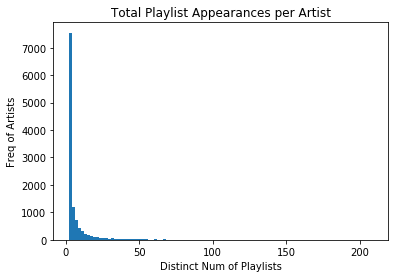

In [95]:
plt.hist(unq_play[(unq_play['playlistname'] > 1)]['playlistname'], bins=100)
plt.xlabel('Distinct Num of Playlists')
plt.ylabel('Freq of Artists')
plt.title('Total Playlist Appearances per Artist')
plt.savefig('playlistapp')

In [12]:
# same def as quarter 1
def read_edge(gph, n0, n1):
    if gph.has_edge(n0, n1):
        gph[n0][n1]['weight'] +=1
        return gph[n0][n1]['weight']
    else:
        gph.add_edge(n0, n1, weight=1)
        return 1

In [13]:
%%time
G = nx.Graph()
# if not unique, could weight the number of times the artist appears in that playlist
df2_grp = df2.groupby('playlistname').agg({'artistname': lambda x: (x).unique()})

for i in range(len(df2_grp)):
    
    for a in (df2_grp.iloc[i]):
        for a1, a2 in itertools.combinations(a, 2):
            read_edge(G, a1, a2)


CPU times: user 4.4 s, sys: 167 ms, total: 4.57 s
Wall time: 4.65 s


In [14]:
# threshold = 1
# long_edges = list(filter(lambda e: e[2] <= threshold, (e for e in G.edges.data('weight'))))
# G.remove_edges_from(long_edges)

CPU times: user 43.4 s, sys: 1 s, total: 44.4 s
Wall time: 45.6 s


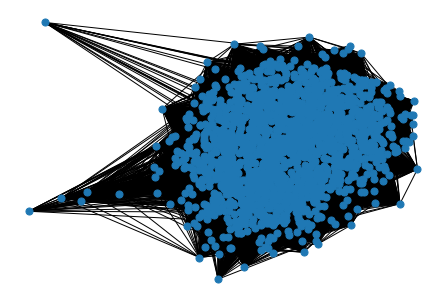

In [15]:
%%time
nx.draw(G, node_size=50)


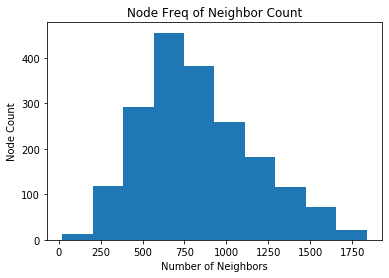

In [84]:
# [n for n in G.neighbors]
neighbors = []
for i in G.nodes:
    count = 0
    for k in G.neighbors(i):
        count += 1
    neighbors.append(count)
neigh_df = pd.DataFrame(G.nodes)
neigh_df['neighbors'] = neighbors
neigh_df
plt.hist(neigh_df['neighbors'])
plt.xlabel('Number of Neighbors')
plt.ylabel('Node Count')
plt.title('Node Freq of Neighbor Count')
plt.savefig('node_freq')

In [17]:
weight_dict = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in node_weights:
    if 'Vampire Weekend' in i:
        weight_dict[i] = node_weights[i]

In [18]:
sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)

[(('Arcade Fire', 'Vampire Weekend'), 28),
 (('Vampire Weekend', 'Arctic Monkeys'), 26),
 (('Vampire Weekend', 'Two Door Cinema Club'), 24),
 (('The Strokes', 'Vampire Weekend'), 22),
 (('Phoenix', 'Vampire Weekend'), 22),
 (('Coldplay', 'Vampire Weekend'), 21),
 (('Florence + The Machine', 'Vampire Weekend'), 21),
 (('Vampire Weekend', 'Daft Punk'), 21),
 (('Vampire Weekend', 'Bon Iver'), 19),
 (('Vampire Weekend', 'Mumford & Sons'), 19),
 (('Yeah Yeah Yeahs', 'Vampire Weekend'), 18),
 (('The xx', 'Vampire Weekend'), 18),
 (('Kings Of Leon', 'Vampire Weekend'), 18),
 (('Vampire Weekend', 'The Black Keys'), 18),
 (('Vampire Weekend', 'Grizzly Bear'), 18),
 (('Vampire Weekend', 'The Smiths'), 18),
 (('M83', 'Vampire Weekend'), 17),
 (('The Rolling Stones', 'Vampire Weekend'), 16),
 (('Radiohead', 'Vampire Weekend'), 16),
 (('Vampire Weekend', 'Fleet Foxes'), 16),
 (('Vampire Weekend', 'Foals'), 16),
 (('Vampire Weekend', 'Franz Ferdinand'), 16),
 (('alt-J', 'Vampire Weekend'), 15),
 (('

In [19]:
len(G.nodes)

1910

In [25]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

def get_artist_genres(artist_names):
    client_id = '8ac5bd4f29854a4abb37648a5b7833d8'
    client_secret = 'c9f1281a0f774d97ae7d002139e53049'
    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    artist_dict = {}
    
    for artist in artist_names:
        result = sp.search(artist, type='artist')['artists']['items']
        if len(result) > 0:
            artist_dict[artist] = result[0]['genres']
    return artist_dict


In [26]:
%%time
genres = get_artist_genres(list(G.nodes))

CPU times: user 7.58 s, sys: 1.31 s, total: 8.89 s
Wall time: 4min 9s


In [22]:
genres

{'!!!': ['alternative dance',
  'dance rock',
  'dance-punk',
  'electroclash',
  'electronica',
  'modern rock',
  'new rave',
  'sacramento indie'],
 '10cc': ['album rock',
  'art rock',
  'blues rock',
  'classic rock',
  'classic uk pop',
  'folk rock',
  'glam rock',
  'mellow gold',
  'rock',
  'singer-songwriter',
  'soft rock',
  'symphonic rock',
  'yacht rock'],
 '2 Chainz': ['atl hip hop',
  'gangster rap',
  'hip hop',
  'pop rap',
  'rap',
  'southern hip hop',
  'trap'],
 '2Pac': ['g funk', 'gangster rap', 'hip hop', 'rap', 'west coast rap'],
 '3 Doors Down': ['alternative metal', 'nu metal', 'pop rock', 'post-grunge'],
 '3OH!3': ['dance pop',
  'electropowerpop',
  'modern rock',
  'pop',
  'pop punk',
  'pop rap',
  'post-teen pop'],
 '4 Non Blondes': ['new wave pop', 'pop rock'],
 '5 Seconds Of Summer': ['boy band', 'dance pop', 'pop', 'post-teen pop'],
 '50 Cent': ['east coast hip hop',
  'gangster rap',
  'hip hop',
  'pop rap',
  'queens hip hop',
  'rap'],
 'A Day 

In [27]:
def filter_dataset(df):
    appearances = df.groupby('artistname').agg({'trackname':'count', 'playlistname':lambda x: len(x.unique())})
    # why are we printing this?
    # print(appearances.sort_values(by=['trackname', 'playlistname']))

    artists = appearances[appearances['playlistname']>=10].index
     # or this?
    # print('# of artists on >= 10 playlists (sample):', len(artists))

    df1 = df[df['artistname'].isin(artists)]

    df1_grped = df1.groupby('playlistname').agg({'artistname':lambda x: len(x.unique())})
    playlists = df1_grped[df1_grped['artistname'] > 1].index
    df2 = df1[df1['playlistname'].isin(playlists)]
    print("dataframe filtered")
    return df2

In [28]:
%%time
genres = get_artist_genres(list(G.nodes)[0:200])

CPU times: user 768 ms, sys: 130 ms, total: 898 ms
Wall time: 25.2 s
